# Historical Precipitation Data for International Falls, Minnesota

International Falls the Rainy River basin are located in a Dfb climate zone characterized by a cold winter, a warm summer, and no evident dry season. The average rainfall of approximately 25 inches (63 cm) is somewhat above the semi-arid conditions to the west.

This notebook provides summaries of precipitation data recorded by the weather station at the International Falls, MN, airport since 1948. The dataset is the daily summary (GHC-Daily CSV) downloaded from https://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND.

<img src="https://upload.wikimedia.org/wikipedia/commons/d/d3/Average_precipitation_in_the_lower_48_states_of_the_USA.png" alt="Average precipitation in the lower 48 states of the USA.png" height="430" width="640"></a><br>
<a href="https://commons.wikimedia.org/w/index.php?curid=666565">Link</a>



## Loading Precipitation Data

Dataset: https://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND

* Search for international falls.
* Select Custom GHCN-Daily CSV
* Include Stations Names, Standard Units, Precipitation

Data file is downloaded and saved as `../../data/weather-inl.csv`


,PRCP,year,month,doy,water_year
DATE,,,,,
1948-01-01,0.00,1948,1,1,1948.0
1948-01-02,0.00,1948,1,2,1948.0
1948-01-03,0.06,1948,1,3,1948.0
1948-01-04,0.00,1948,1,4,1948.0
1948-01-05,0.03,1948,1,5,1948.0
...,...,...,...,...,...
2022-05-21,0.13,2022,5,141,2022.0
2022-05-22,0.00,2022,5,142,2022.0
2022-05-23,0.00,2022,5,143,2022.0


<AxesSubplot:title={'center':'INTERNATIONAL FALLS INTERNATIONAL AIRPORT, MN US'}, xlabel='DATE', ylabel='Inches'>

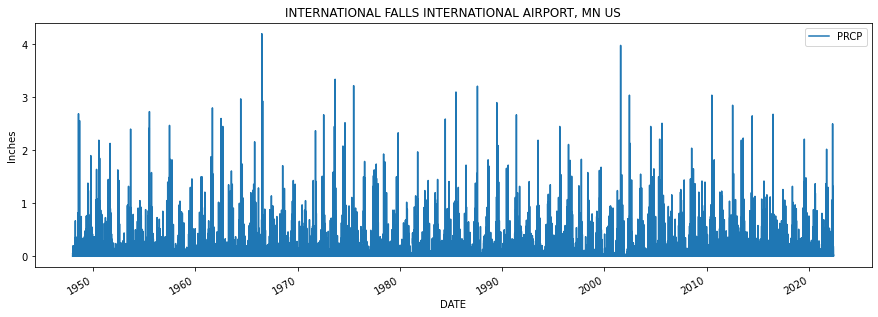

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd

def read_prcp(datafile="../../data/weather-inl.csv", station="USW00014918"):
    
    # read downloaded dataset
    df = pd.read_csv(datafile, usecols=["STATION", "NAME", "DATE", "PRCP"])
    
    # select international falls airport station
    df = df[df["STATION"]==station]
    
    # convert to pandas datetime format
    dates = pd.to_datetime(df.loc[:, "DATE"])
    df.loc[:, "DATE"] = dates
    
    # select modern data series since 1948
    df = df[df["DATE"] >= dt.datetime(1948, 1, 1)]
    name = df["NAME"].loc[min(df.index)]
    df = df.loc[:, ["DATE", "PRCP"]]
    df = df.dropna()
    
    df['year'] = df['DATE'].dt.year
    df['month'] = df['DATE'].dt.month
    df['doy'] = df['DATE'].dt.dayofyear

    # determine water_year
    for i in df.index:
        yr = df.loc[i, "DATE"].year
        if df.loc[i, "DATE"].month <= 9:
            df.loc[i, "water_year"] = int(yr)
        else:
            df.loc[i, "water_year"] = int(yr + 1)
    df = df.set_index("DATE")
    df.name = name
    return df

prcp = read_prcp()
display(prcp)
prcp.plot(y="PRCP", figsize=(15, 5), ylabel="Inches", title=prcp.name)

## Annual Precipitation Patterns

This first analysis summarizes the distribution of total annual precipitation.

* Benestad, R. E., Nychka, D., & Mearns, L. O. (2012). Spatially and temporally consistent prediction of heavy precipitation from mean values. Nature Climate Change, 2(7), 544-547.

The observed average precipitation of 24.7 inches is the central value of a non-Gaussian distribution of annual precipitation. 

### Computing annual precipitation series

year
1949    30.16
1950    32.44
1951    28.04
1952    17.23
1953    25.49
        ...  
2017    23.55
2018    24.38
2019    32.79
2020    21.44
2021    20.83
Name: PRCP, Length: 73, dtype: float64

(0.0, 34.4295)

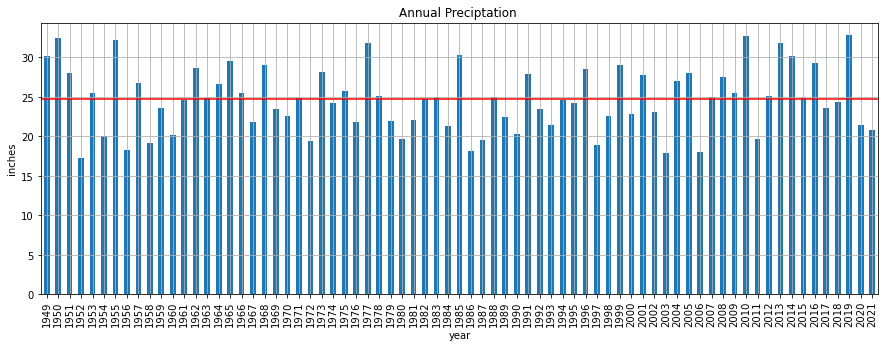

In [2]:
# compute annual prcp time series
annual_prcp = prcp.groupby(["year"])["PRCP"].sum()[1:-1]
display(annual_prcp)

# plot annual precipitation
figsize=(15, 5)
ax = annual_prcp.plot(kind='bar', 
                      ylabel="inches",
                      xlabel="year",
                      title="Annual Preciptation ", 
                      figsize=figsize, 
                      grid=True)
ax.axhline(annual_prcp.mean(), color='r')
ax.set_ylim(0, )

### Descriptive Statistics of Annual Precipitation

In [3]:
display(annual_prcp.describe())

count    73.000000
mean     24.689178
std       4.078632
min      17.230000
25%      21.800000
50%      24.720000
75%      27.850000
max      32.790000
Name: PRCP, dtype: float64

### Exceedance

Exceedance probability is a statistical technique for the analysis of climate and weather related events. For example, a "100 year flood" refers to a flood level that has a 1% chance of being equaled or exceeded in a given year.  

Given an array of value $y_i $, the probability of exceedance is estimated as

$$p_i = \frac{r_i}{n + 1}$$

where $r_i$ is the rank of $y_i$ when sorted into descending order.

Text(0, 0.5, 'probability')

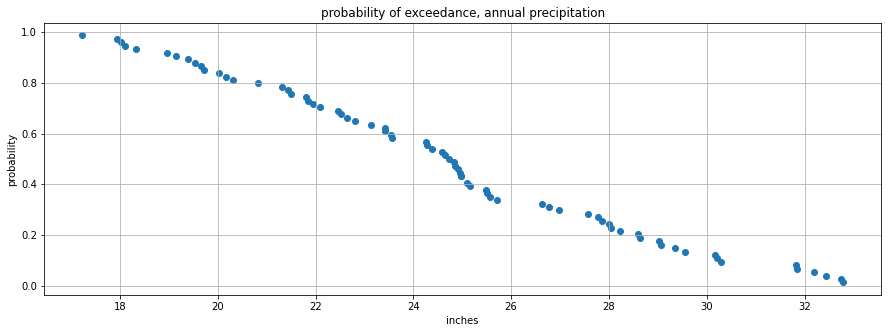

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

n = len(annual_prcp)
r = np.array(n - stats.rankdata(annual_prcp, method="average").astype(int))

# python uses zero-based ranking
p = (r + 1)/(n + 1)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.scatter(annual_prcp, p)
ax.grid(True)
ax.set_title('probability of exceedance, annual precipitation')
ax.set_xlabel('inches')
ax.set_ylabel('probability')

### Trendlines for Annual Precipitation

Climate change has had profound affect on precipitation patterns in different parts of the continent and globe. This cell tests for any statisically significant trend in the total annual precipitation measured at International Falls, MN.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   PRCP   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.1097
Date:                Wed, 08 Jun 2022   Prob (F-statistic):              0.741
Time:                        15:23:43   Log-Likelihood:                -205.64
No. Observations:                  73   AIC:                             415.3
Df Residuals:                      71   BIC:                             419.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.6988     45.253      0.214      0.831     -80.533      99.931
year           0.0076      0.023      0.331      0.741      -0.038       0.053
==============================================================================
Omnibus:                        4.018   Durbin-Watson:                   2.268
Prob(Omnibus):                  0.134   Jarque-Bera (JB):                2.295
Skew:                           0.189   Prob(JB):                        0.317
Kurtosis:                       2.218   Cond. No.                     1.87e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

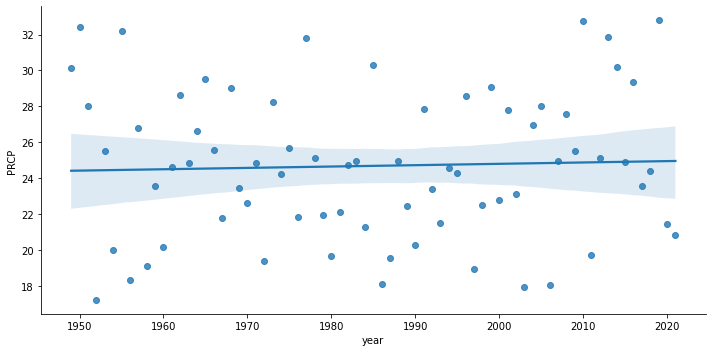

In [52]:
import seaborn as sns
import statsmodels.formula.api as sm

df = pd.DataFrame(annual_prcp)
df["year"] = df.index

sns.lmplot(x="year", y="PRCP", data=df, height=5, aspect=2)
result = sm.ols(formula="PRCP ~ year", data=df).fit()
result.summary()

## Patterns in Daily Precipitation

In [109]:
!pip install distfit

## Wet days

1.3820109274825538 0.0 0.12818426369981686


Text(0.5, 0, 'inches')

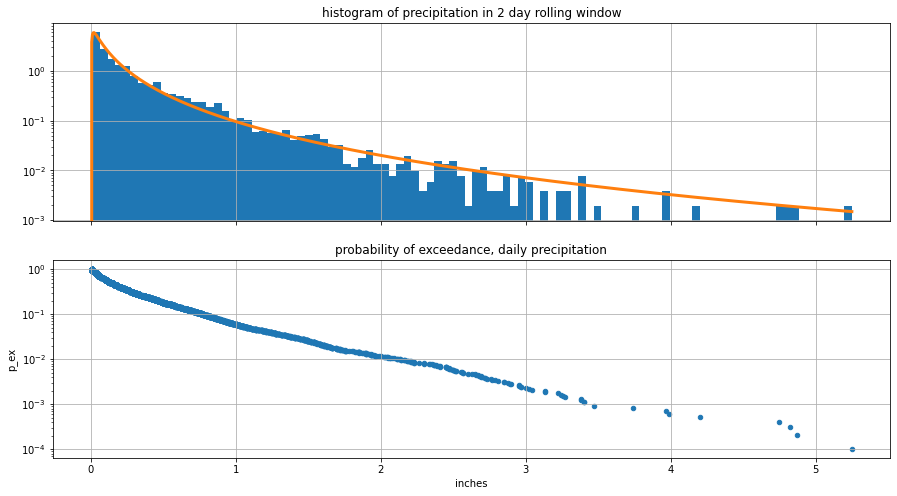

In [163]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from distfit import distfit

# rolling windows to account for sustained rain events
n_day = 2

# extract wet days
#prcp["rolling"] = prcp["PRCP"].rolling(window=n_day).sum()

prcp["rolling"] = prcp["PRCP"].rolling(window=n_day).sum()
wet_days = prcp[prcp["PRCP"] > 0.0][["PRCP", "year", "rolling"]]
#wet_days["rolling"] = wet_days["PRCP"].rolling(window=n_day).sum()
wet_days = wet_days.dropna()

# lognormal
shape, loc, scale = stats.lognorm.fit(wet_days["rolling"], floc=0)
x = np.linspace(0, wet_days["rolling"].max(), 1000)
p = stats.lognorm.pdf(x, shape, loc, scale)
print(shape, loc, scale)

# histogram
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
wet_days["rolling"].hist(ax=ax[0], bins=100, log=True, density=True)
ax[0].set_title(f"histogram of precipitation in {n_day} day rolling window")
ax[0].plot(x, p, lw=3)

# exceedance
n = len(wet_days)
r = np.array(n - stats.rankdata(wet_days["rolling"], method="average").astype(int))

# python uses zero-based ranking
wet_days["p_ex"] = (r + 1)/(n + 1)
wet_days.plot(ax=ax[1], kind="scatter", x="rolling", y="p_ex", logy=True)

ax[1].grid(True)
ax[1].set_title('probability of exceedance, daily precipitation')
ax[1].set_xlabel('inches')

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 13.7543] [loc=0.296 scale=0.426]
[distfit] >[expon     ] [0.00 sec] [RSS: 2.7423] [loc=0.010 scale=0.286]
[distfit] >[pareto    ] [0.14 sec] [RSS: 0.357643] [loc=-0.363 scale=0.373]
[distfit] >[dweibull  ] [0.28 sec] [RSS: 3.14302] [loc=0.070 scale=0.361]
[distfit] >[t         ] [0.05 sec] [RSS: 3.64727] [loc=0.105 scale=0.102]
[distfit] >[genextreme] [0.25 sec] [RSS: 0.192114] [loc=0.075 scale=0.092]
[distfit] >[gamma     ] [0.12 sec] [RSS: 5.9637] [loc=0.010 scale=1.288]
[distfit] >[lognorm   ] [0.07 sec] [RSS: 0.180912] [loc=0.006 scale=0.109]
[distfit] >[beta      ] [0.28 sec] [RSS: 5.54775] [loc=0.010 scale=80.318]
[distfit] >[uniform   ] [0.00 sec] [RSS: 21.4289] [loc=0.010 scale=5.240]
[distfit] >[loggamma  ] [0.12 sec] [RSS: 13.9811] [loc=-204.247 scale=25.346]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'\nlognorm\nRSS(s=1.60542, loc=0.00645897, scale=0.108947)'}, xlabel='Values', ylabel='Frequency'>)

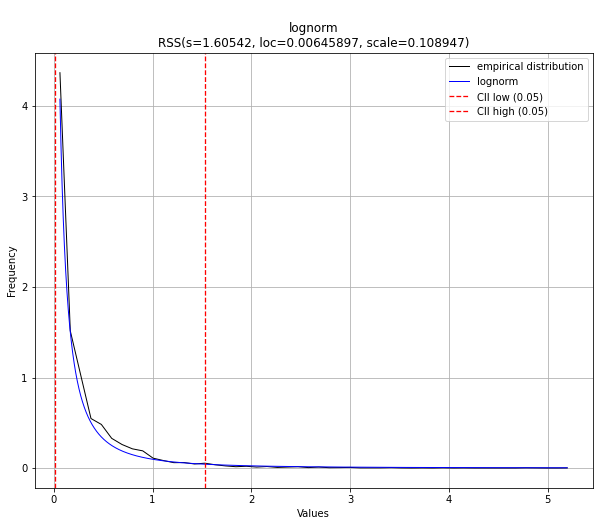

In [164]:
dist = distfit()
wet_days = wet_days.dropna()
dist.fit_transform(wet_days["rolling"])
dist.plot()

TypeError: _parse_args() got an unexpected keyword argument 'c'

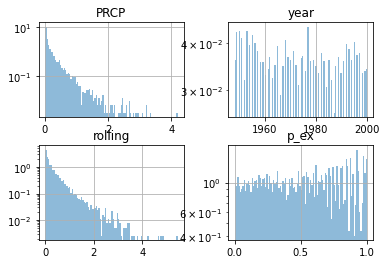

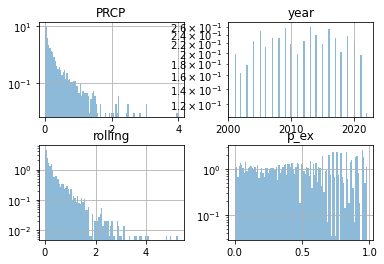

In [162]:
ax = wet_days[wet_days["year"] <= 2000].hist(bins=100, log=True, density=True, alpha=0.5)
ax = wet_days[wet_days["year"] > 2000].hist(bins=100, log=True, density=True, alpha=0.5)

c, loc = stats.gumbel_r.fit(wet_days["PRCP"])

x = np.linspace(0, 5, 1000)
y = stats.gumbel_r.pdf(x-loc, c=c)
ax.plot(x, y)

In [ ]:
prcp["PRCP"].sort_values(by=["PRCP"])

## Monthly Precipitation

<AxesSubplot:>

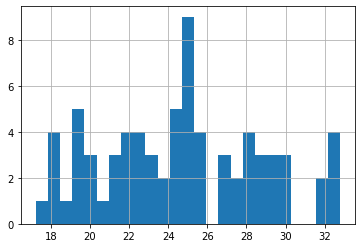

In [10]:
monthly_prcp = prcp.groupby(["year", "month"])["PRCP"].sum().to_frame()
monthly_prcp = pd.pivot_table(monthly_prcp, index="year", columns="month")


monthly_prcp.sum(axis=1)[1:-1].hist(bins=25)

PRCP                                                                  
month    1     2     3     4     5     6     7     8     9     10    11    12
year                                                                         
1948    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  0.86  1.48  1.10
1949   1.40  0.94  1.08  1.14  3.59  4.51  5.93  3.20  1.39  4.66  1.31  1.01
1950   1.24  0.47  1.49  2.03  5.31  3.68  6.89  3.43  3.50  1.96  1.71  0.73
1951   0.39  1.76  2.95  1.31  1.18  3.84  2.05  6.58  3.57  2.16  1.10  1.15
1952   0.58  0.27  0.87  0.45  0.52  5.17  6.05  1.09  0.28  0.65  0.86  0.44
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
2018   0.71  0.98  0.35  0.36  3.70  4.03  2.58  2.90  3.66  3.52  0.76  0.83
2019   0.68  1.66  0.81  1.58  2.59  1.99  5.56  4.09  6.64  4.90  0.85  1.44
2020   1.21  0.24  0.78  0.86  1.09  2.93  3.37  4.80  1.81  2.70  0.49  1.16
2021   0.68  0.14  0.36  3.50  0.62  1.71  1.35  2.80  3.23  2.77  1.82  1.85
2022   0.95  1.48  1.22  7.61  2.57   NaN   NaN   NaN   NaN   NaN   NaN   NaN

[75 rows x 12 columns]

KeyError: 'month'

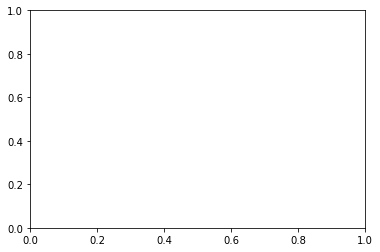

In [407]:
monthly_prcp = prcp.groupby(["year", "month"])["PRCP"].sum().to_frame()
monthly_prcp = pd.pivot_table(monthly_prcp, index="year", columns="month")

display(monthly_prcp)
fig, ax = plt.subplots(1, 1)
monthly_prcp.groupby("month").quantile(1.00).plot(ax=ax, style='.')
monthly_prcp.groupby("month").quantile(0.90).plot(ax=ax, color='b')
monthly_prcp.groupby("month").quantile(0.50).plot(ax=ax, color='b')
monthly_prcp.groupby("month").quantile(0.10).plot(ax=ax, color='b')
monthly_prcp.groupby("month").quantile(0.00).plot(ax=ax, style='.')
ax.set_xlim(0,)


<bound method _AxesBase.get_yticks of <AxesSubplot:>>


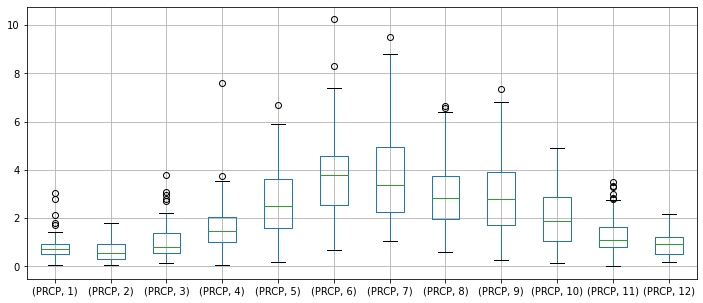

In [403]:
monthly_prcp = prcp.groupby(["year", "month"])["PRCP"].sum().to_frame()
monthly_prcp = pd.pivot_table(monthly_prcp, index="year", columns="month")
ax = monthly_prcp.boxplot(figsize=(12, 5))
ax.set_ylabel = "Inches"
ax.set_title = "Monthly Precipitation Patterns International Falls 1949-2022"
print(ax.get_yticks)

month
1     AxesSubplot(0.125,0.125;0.775x0.755)
2     AxesSubplot(0.125,0.125;0.775x0.755)
3     AxesSubplot(0.125,0.125;0.775x0.755)
4     AxesSubplot(0.125,0.125;0.775x0.755)
5     AxesSubplot(0.125,0.125;0.775x0.755)
6     AxesSubplot(0.125,0.125;0.775x0.755)
7     AxesSubplot(0.125,0.125;0.775x0.755)
8     AxesSubplot(0.125,0.125;0.775x0.755)
9     AxesSubplot(0.125,0.125;0.775x0.755)
10    AxesSubplot(0.125,0.125;0.775x0.755)
11    AxesSubplot(0.125,0.125;0.775x0.755)
12    AxesSubplot(0.125,0.125;0.775x0.755)
Name: PRCP, dtype: object

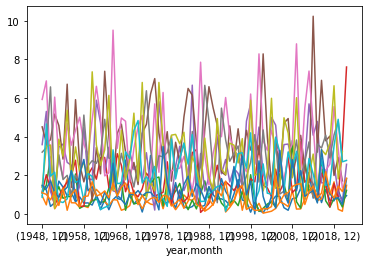

In [272]:
import numpy as np

monthly_prcp = prcp.groupby(["year", "month"])["PRCP"].sum()
monthly_prcp.groupby("month").plot()



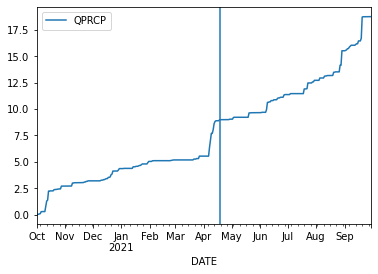

In [217]:
def weather_year(yr):
    start = datetime.datetime(yr-1, 10, 1)
    end = datetime.datetime(yr, 9, 30)
    df = weather[weather["DATE"] >= start]
    df = df[df["DATE"] <= end]
    df["QPRCP"] = df["PRCP"].cumsum()
    return df

def ice_out():
    data_file = "../../data/ice_out_dates_rainy_lake.txt"
    # Read .csv file
    df = pd.read_csv(data_file, skiprows=1)
    df.columns = ["date", "source", "comments"]

    # Create a new independent variable that counts years from the first date in the data set
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['doy'] = df['date'].dt.dayofyear
    df['n'] = df['year'] - df['year'][0]

    # Drop unneeded columns
    df = df.drop(labels='source', axis=1)
    df = df.drop(labels='comments', axis=1)
    df.index = df["year"]
    return df

df_ice_out = ice_out()

yr = 2021
    
w = weather_year(yr)
ax = w.plot(x="DATE", y="QPRCP")
ax.axvline(df_ice_out["date"][yr])